In [1]:
import pandas as pd
import numpy as np

from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from xgboost.callback import EarlyStopping
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

In [10]:
## 데이터 로딩 및 전처리
# 데이터 불러오기
call_df = pd.read_csv("call119_train.csv", index_col=0)
cat_df = pd.read_csv("cat119_train.csv", index_col=0)

# 컬럼명 변경
call_df = call_df.rename(columns={
    'call119_train.tm': 'tm',
    'call119_train.address_city': 'city',
    'call119_train.address_gu': 'gu',
    'call119_train.sub_address': 'dong',
    'call119_train.stn': 'stn',
    'call119_train.ta_max': 'ta_max',
    'call119_train.ta_min': 'ta_min',
    'call119_train.ta_max_min': 'ta_max_min',
    'call119_train.hm_min': 'hm_min',
    'call119_train.hm_max': 'hm_max',
    'call119_train.ws_max': 'ws_max',
    'call119_train.ws_ins_max': 'ws_ins_max',
    'call119_train.rn_day': 'rn_day',
    'call119_train.call_count': 'call_total'
})

cat_df = cat_df.rename(columns={
    'cat119_train.tm': 'tm',
    'cat119_train.address_city': 'city',
    'cat119_train.address_gu': 'gu',
    'cat119_train.sub_address': 'dong',
    'cat119_train.cat': 'cat',
    'cat119_train.sub_cat': 'sub_cat',
    'cat119_train.stn': 'stn',
    'cat119_train.call_count': 'call_cat_sum'
})

# 숫자형 변환
num_cols = ['ta_max', 'ta_min', 'ta_max_min', 'hm_min', 'hm_max', 'ws_max', 'ws_ins_max', 'rn_day']
for col in num_cols:
    call_df[col] = pd.to_numeric(call_df[col], errors='coerce')
    call_df[col] = call_df[col].replace(-99.0, np.nan)

# 결측치 제거
call_df = call_df.dropna(subset=num_cols + ['call_total'])
cat_df = cat_df.dropna(subset=['call_cat_sum'])

# 병합
merged_df = pd.merge(call_df, cat_df, on=['tm', 'city', 'gu', 'dong', 'stn'], how='left')
merged_df['call_cat_sum'] = merged_df['call_cat_sum'].fillna(0)

# 불필요한 컬럼 제거 및 결측 처리
merged_df = merged_df.drop(columns=['city', 'gu', 'dong', 'sub_cat'])
cat_cols = ['cat']
for col in cat_cols:
    merged_df[col] = merged_df[col].fillna('unknown')

# Feature / Target
features = num_cols + cat_cols
target = 'call_total'
X = merged_df[features]
y = np.log1p(merged_df[target])  # 로그 변환

# Train/Validation Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
## 범주형 인코딩
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train_enc = X_train.copy()
X_val_enc = X_val.copy()

X_train_enc[cat_cols] = encoder.fit_transform(X_train[cat_cols])
X_val_enc[cat_cols] = encoder.transform(X_val[cat_cols])

In [12]:
###  XGB 파라미터 자동 튜닝 (튜닝할때만 실행) ###
import optuna
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

def objective_xgb(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 7600, 7800),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.02, log=True),
        "max_depth": trial.suggest_int("max_depth", 7, 10),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 0.05),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 0.5),
        "random_state": 42,
        "tree_method": "hist"
    }

    model = XGBRegressor(**params)
    model.fit(X_train_enc, y_train, verbose=False)

    y_pred = model.predict(X_val_enc)
    mse = mean_squared_error(y_val, y_pred)
    
    return mse

print("=== XGBoost 자동 튜닝 시작 ===")
study_xgb = optuna.create_study(direction="minimize")
study_xgb.optimize(objective_xgb, n_trials=5)                   # 시도횟수 조정 가능
print("XGBoost Best hyperparameters:", study_xgb.best_params)
print("XGBoost Best MSE:", study_xgb.best_value)

[I 2025-06-24 21:58:57,120] A new study created in memory with name: no-name-55c4d7e4-2e20-41c7-ab4b-790926f70e2d


=== XGBoost 자동 튜닝 시작 ===


[I 2025-06-24 21:59:03,279] Trial 0 finished with value: 0.1678496789839356 and parameters: {'n_estimators': 7633, 'learning_rate': 0.010191019621401242, 'max_depth': 7, 'colsample_bytree': 0.7529048439260968, 'reg_alpha': 0.017541499318524844, 'reg_lambda': 0.41642585103364116}. Best is trial 0 with value: 0.1678496789839356.
[I 2025-06-24 21:59:12,624] Trial 1 finished with value: 0.18529630342523964 and parameters: {'n_estimators': 7739, 'learning_rate': 0.019287142874276245, 'max_depth': 8, 'colsample_bytree': 0.7377606146072427, 'reg_alpha': 0.020383857490068897, 'reg_lambda': 0.3763044486943989}. Best is trial 0 with value: 0.1678496789839356.
[I 2025-06-24 21:59:23,669] Trial 2 finished with value: 0.18620149568068636 and parameters: {'n_estimators': 7619, 'learning_rate': 0.01248962543843833, 'max_depth': 9, 'colsample_bytree': 0.868611496470951, 'reg_alpha': 0.0033090007005300627, 'reg_lambda': 0.3331917953839976}. Best is trial 0 with value: 0.1678496789839356.
[I 2025-06-24 

XGBoost Best hyperparameters: {'n_estimators': 7633, 'learning_rate': 0.010191019621401242, 'max_depth': 7, 'colsample_bytree': 0.7529048439260968, 'reg_alpha': 0.017541499318524844, 'reg_lambda': 0.41642585103364116}
XGBoost Best MSE: 0.1678496789839356


In [13]:
###  Cat 파라미터 자동 튜닝 (튜닝할때만 실행) ###
def objective_cat(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 2500, 4500),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.02, log=True),
        "depth": trial.suggest_int("depth", 4, 7),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0.0, 0.05),
        "random_seed": 42,
        "verbose": False,
        "allow_writing_files": False
    }

    model = CatBoostRegressor(**params)
    
    # 원본 데이터 사용 (X_train, X_val)
    model.fit(
        X_train, y_train, 
        cat_features=cat_cols,  # ['gu', 'dong', 'cat', 'sub_cat']
        eval_set=(X_val, y_val), 
        early_stopping_rounds=100, 
        verbose=False
    )

    y_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    
    return mse

print("\n=== CatBoost 자동 튜닝 시작 ===")
study_cat = optuna.create_study(direction="minimize")
study_cat.optimize(objective_cat, n_trials=5)         # 시도횟수 조정 가능
print("CatBoost Best hyperparameters:", study_cat.best_params)
print("CatBoost Best MSE:", study_cat.best_value)

[I 2025-06-24 21:59:55,862] A new study created in memory with name: no-name-7c4c3829-dda4-444a-b7c1-84891a315a7f



=== CatBoost 자동 튜닝 시작 ===


[I 2025-06-24 22:00:31,824] Trial 0 finished with value: 0.1648623884001143 and parameters: {'iterations': 2832, 'learning_rate': 0.01982403398257789, 'depth': 4, 'l2_leaf_reg': 0.03500676611950822}. Best is trial 0 with value: 0.1648623884001143.
[I 2025-06-24 22:01:19,661] Trial 1 finished with value: 0.1643933977405723 and parameters: {'iterations': 3649, 'learning_rate': 0.01713229644033012, 'depth': 4, 'l2_leaf_reg': 0.009542051702969496}. Best is trial 1 with value: 0.1643933977405723.
[I 2025-06-24 22:02:24,982] Trial 2 finished with value: 0.16324968996867603 and parameters: {'iterations': 2902, 'learning_rate': 0.01178739744358301, 'depth': 6, 'l2_leaf_reg': 0.006687805633276517}. Best is trial 2 with value: 0.16324968996867603.
[I 2025-06-24 22:03:27,431] Trial 3 finished with value: 0.16337178781965248 and parameters: {'iterations': 2808, 'learning_rate': 0.011966847814993053, 'depth': 6, 'l2_leaf_reg': 0.01783858864895842}. Best is trial 2 with value: 0.16324968996867603.
[

CatBoost Best hyperparameters: {'iterations': 2902, 'learning_rate': 0.01178739744358301, 'depth': 6, 'l2_leaf_reg': 0.006687805633276517}
CatBoost Best MSE: 0.16324968996867603


In [14]:
# ===================================
# 최적 파라미터로 모델 자동 학습
# ===================================

print("\n=== 최적 파라미터로 모델 학습 ===")

# XGBoost 최적 모델 학습
print("XGBoost 모델 학습 중...")
best_xgb_params = study_xgb.best_params.copy()
best_xgb_params.update({
    "random_state": 42,
    "tree_method": "hist"
})

xgb_model = XGBRegressor(**best_xgb_params)
xgb_model.fit(X_train_enc, y_train, verbose=100)

# CatBoost 최적 모델 학습
print("\nCatBoost 모델 학습 중...")
best_cat_params = study_cat.best_params.copy()
best_cat_params.update({
    "random_seed": 42,
    "verbose": 100,
    "loss_function": "RMSE"
})

catboost_model = CatBoostRegressor(**best_cat_params)
catboost_model.fit(
    X_train, y_train, 
    cat_features=cat_cols, 
    eval_set=(X_val, y_val), 
    early_stopping_rounds=100
)

# ===================================
# 모델 성능 평가
# ===================================

print("\n=== 모델 성능 평가 ===")

# XGBoost 평가
xgb_pred = xgb_model.predict(X_val_enc)
xgb_mse = mean_squared_error(y_val, xgb_pred)
xgb_rmse = np.sqrt(xgb_mse)

# CatBoost 평가
cat_pred = catboost_model.predict(X_val)
cat_mse = mean_squared_error(y_val, cat_pred)
cat_rmse = np.sqrt(cat_mse)

print(f"XGBoost - MSE: {xgb_mse:.6f}, RMSE: {xgb_rmse:.6f}")
print(f"CatBoost - MSE: {cat_mse:.6f}, RMSE: {cat_rmse:.6f}")


=== 최적 파라미터로 모델 학습 ===
XGBoost 모델 학습 중...

CatBoost 모델 학습 중...
0:	learn: 0.4386269	test: 0.4378235	best: 0.4378235 (0)	total: 18.3ms	remaining: 53.2s
100:	learn: 0.4224658	test: 0.4195603	best: 0.4195603 (100)	total: 1.9s	remaining: 52.6s
200:	learn: 0.4186377	test: 0.4158018	best: 0.4158018 (200)	total: 3.74s	remaining: 50.3s
300:	learn: 0.4166141	test: 0.4141697	best: 0.4141697 (300)	total: 5.59s	remaining: 48.3s
400:	learn: 0.4151574	test: 0.4131261	best: 0.4131261 (400)	total: 7.41s	remaining: 46.2s
500:	learn: 0.4139178	test: 0.4123239	best: 0.4123239 (500)	total: 9.23s	remaining: 44.2s
600:	learn: 0.4128611	test: 0.4116934	best: 0.4116934 (600)	total: 11s	remaining: 42.2s
700:	learn: 0.4119282	test: 0.4111173	best: 0.4111173 (700)	total: 12.8s	remaining: 40.3s
800:	learn: 0.4109456	test: 0.4106027	best: 0.4106027 (800)	total: 14.6s	remaining: 38.4s
900:	learn: 0.4099359	test: 0.4100643	best: 0.4100643 (900)	total: 16.5s	remaining: 36.6s
1000:	learn: 0.4089609	test: 0.4095964	bes

In [6]:
#################
## 모델 수동학습 ##
#################

# CatBoost
catboost_model = CatBoostRegressor(
    iterations=1500,
    learning_rate=0.02,
    depth=4,
    l2_leaf_reg=5,
    bagging_temperature=1.0,
    random_strength=1.5,
    random_seed=42,
    verbose=100,
    loss_function="RMSE"
)
catboost_model.fit(X_train, y_train, cat_features=cat_cols, eval_set=(X_val, y_val), early_stopping_rounds=100)

# XGBoost
xgb_model = XGBRegressor(
    n_estimators=2765,
    learning_rate=0.01666987439817238,
    max_depth=6,
    colsample_bytree=0.952258400174878,
    reg_alpha=0.004261234885452697,
    reg_lambda=0.1446413754321237,
    random_state=42,
    tree_method="hist"
)
xgb_model.fit(
    X_train_enc,
    y_train,
    verbose=True
)

0:	learn: 0.4373694	test: 0.4365810	best: 0.4365810 (0)	total: 144ms	remaining: 3m 35s
100:	learn: 0.3901130	test: 0.3862573	best: 0.3862573 (100)	total: 1.33s	remaining: 18.4s
200:	learn: 0.3848006	test: 0.3804731	best: 0.3804731 (200)	total: 2.52s	remaining: 16.3s
300:	learn: 0.3830298	test: 0.3786466	best: 0.3786466 (300)	total: 3.76s	remaining: 15s
400:	learn: 0.3820822	test: 0.3778114	best: 0.3778114 (400)	total: 4.97s	remaining: 13.6s
500:	learn: 0.3812500	test: 0.3770806	best: 0.3770806 (500)	total: 6.26s	remaining: 12.5s
600:	learn: 0.3803106	test: 0.3763555	best: 0.3763555 (600)	total: 7.52s	remaining: 11.2s
700:	learn: 0.3794513	test: 0.3757948	best: 0.3757948 (700)	total: 8.77s	remaining: 10s
800:	learn: 0.3786643	test: 0.3752348	best: 0.3752348 (800)	total: 10s	remaining: 8.74s
900:	learn: 0.3779594	test: 0.3748582	best: 0.3748582 (900)	total: 11.3s	remaining: 7.5s
1000:	learn: 0.3773381	test: 0.3745578	best: 0.3745578 (1000)	total: 12.6s	remaining: 6.26s
1100:	learn: 0.376

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.952258400174878
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [7]:
## 예측 및 평가
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_true), np.expm1(y_pred)))

print("CatBoost RMSE:", rmse(y_val, catboost_model.predict(X_val)))
print("XGBoost  RMSE:", rmse(y_val, xgb_model.predict(X_val_enc)))

CatBoost RMSE: 1.7700670200721966
XGBoost  RMSE: 1.7112142122708058


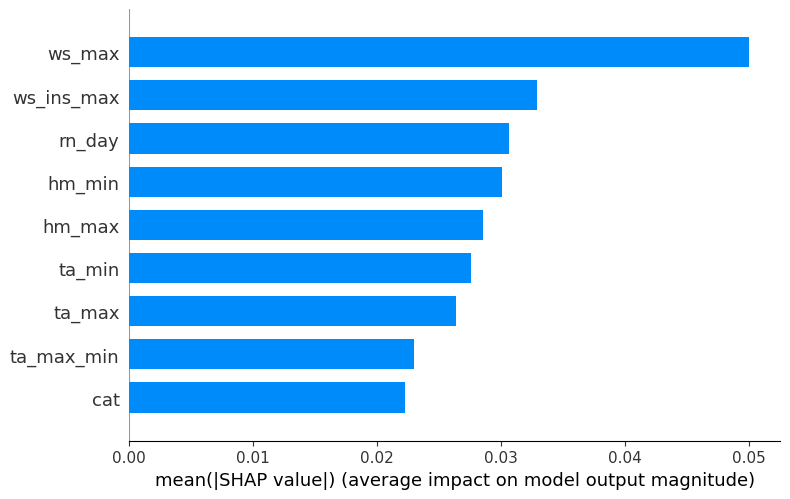

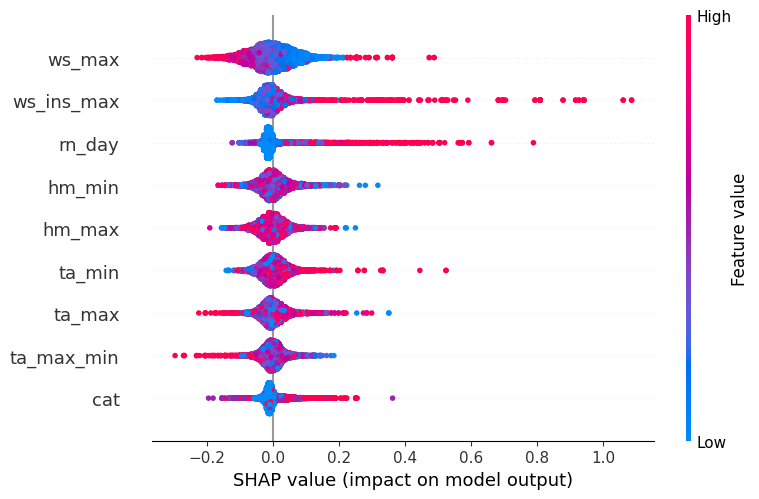

In [16]:
import shap

# Tree 기반 XGBoost 모델용 Explainer 생성
explainer_xgb = shap.Explainer(xgb_model)

# SHAP 값 계산 - 범주형 인코딩된 검증 데이터 사용
shap_values_xgb = explainer_xgb(X_val_enc)

# 중요도 시각화
shap.summary_plot(shap_values_xgb, X_val_enc, plot_type="bar", show=True)  # 막대 그래프
shap.summary_plot(shap_values_xgb, X_val_enc, show=True)  # beeswarm


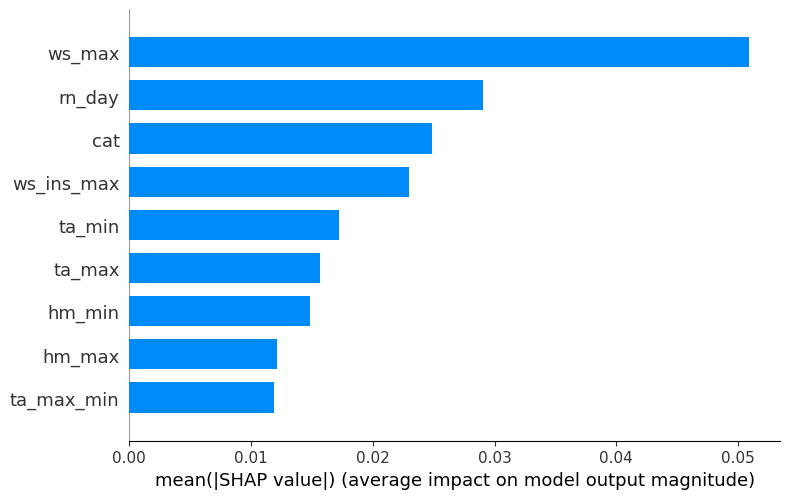

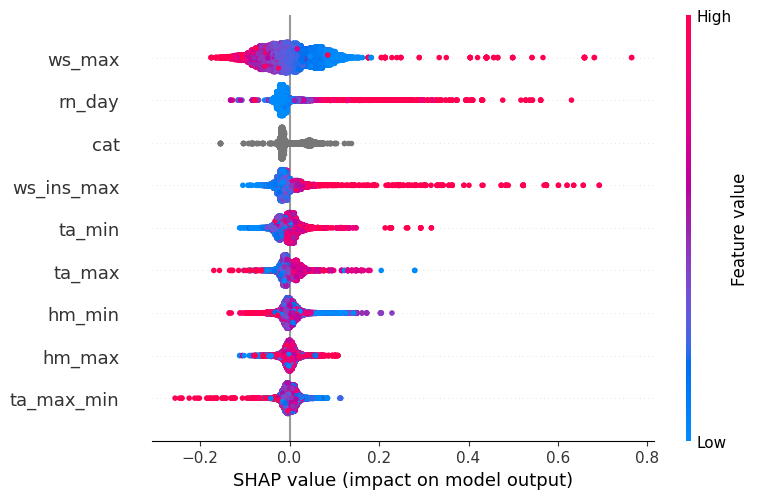

In [15]:
import shap

# CatBoost는 그대로 SHAP 분석 가능 (인코딩 필요 없음)
explainer_cat = shap.Explainer(catboost_model)

# SHAP 값 계산 - 원본 검증 데이터 사용
shap_values_cat = explainer_cat(X_val)

# 중요도 시각화
shap.summary_plot(shap_values_cat, X_val, plot_type="bar", show=True)
shap.summary_plot(shap_values_cat, X_val, show=True)

In [17]:
## 테스트 데이터에 적용
# 테스트 데이터 불러오기
test_call_df = pd.read_csv("test_call119.csv")
test_cat_df = pd.read_csv("test_cat119.csv")
output_base = test_call_df.copy()

# 컬럼명 변경
test_call_df = test_call_df.rename(columns={
    'TM': 'tm',
    'address_city': 'city',
    'address_gu': 'gu',
    'sub_address': 'dong',
    'STN': 'stn',
    'call_count': 'call_total'
})

test_cat_df = test_cat_df.rename(columns={
    'TM': 'tm',
    'address_city': 'city',
    'address_gu': 'gu',
    'sub_address': 'dong',
    'STN': 'stn'
})

# 숫자형 처리
for col in num_cols:
    test_call_df[col] = pd.to_numeric(test_call_df[col], errors='coerce')
    test_call_df[col] = test_call_df[col].replace(-99.0, np.nan)

# 병합 및 결측 처리
test_df = pd.merge(test_call_df, test_cat_df, on=['tm', 'city', 'gu', 'dong', 'stn'], how='left')
test_df['cat'] = test_df.get('cat', 'unknown').fillna('unknown')
test_df['sub_cat'] = test_df.get('sub_cat', 'unknown').fillna('unknown')
test_df = test_df.drop(columns=['city'])

# 범주형 결측 처리
for col in cat_cols:
    test_df[col] = test_df[col].fillna('unknown')

# merge_key 생성
test_df['merge_key'] = (
    test_df['tm'].astype(str) + '_' +
    test_df['gu'] + '_' +
    test_df['dong'] + '_' +
    test_df['stn'].astype(str)
)

# 예측용 feature
X_test = test_df[features]
X_test_enc = X_test.copy()
X_test_enc[cat_cols] = encoder.transform(X_test[cat_cols])

# 예측 수행 및 앙상블 평균
pred_cb = np.expm1(catboost_model.predict(X_test))
pred_xgb = np.expm1(xgb_model.predict(X_test_enc))

# 앙상블 가중치
test_df['predicted_call_total'] = (pred_cb * 0.50) + (pred_xgb * 0.50)

# 그룹 평균
agg_preds_df = test_df.groupby('merge_key')['predicted_call_total'].mean().reset_index()

# 원본 테스트셋과 merge
output_base['merge_key'] = (
    output_base['TM'].astype(str) + '_' +
    output_base['address_gu'] + '_' +
    output_base['sub_address'] + '_' +
    output_base['STN'].astype(str)
)

output_base = output_base.merge(agg_preds_df, on='merge_key', how='left')
output_base['call_count'] = output_base['predicted_call_total'].round().astype(int)
output_base = output_base.drop(columns=['merge_key', 'predicted_call_total'])

# 결과 저장
output_base.to_csv("call119_ensemble_predictions.csv", index=False)
print("예측 결과 저장 완료: call119_ensemble_predictions.csv")

예측 결과 저장 완료: call119_ensemble_predictions.csv


In [18]:
from sklearn.metrics import mean_squared_error

# 파일 경로 설정
file1 = 'call119_ensemble_predictions.csv'

# CSV 파일 읽기
df1 = pd.read_csv(file1)

# call_count 열 평균 및 합계 계산
mean = df1['call_count'].mean()
mean_squared1 = (df1['call_count'] ** 2).mean()
sum1 = df1['call_count'].sum()

print(f"평균: {mean}, 평균제곱값: {mean_squared1}, 합계: {sum1}")

평균: 2.017810644724508, 평균제곱값: 4.1944589105301535, 합계: 19373
